In [ ]:
# Script réalisant :

# extraction de features d'images,
# + PCA,
# + enregistrement des résultats,

# depuis un environnement sur le cloud, où tout est hébergé
# (données, script, résultats).


## 1 Mise en place de l'environnement


### 1.1 Authentification


In [ ]:
# Rappel
# Vérifions que nous avons l'authentification nécessaire

# Console (ubuntu debian):
# (activate env)

# install package(s):
# sudo apt-get install apt-transport-https ca-certificates gnupg curl
# curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo gpg --dearmor -o /usr/share/keyrings/cloud.google.gpg
# echo "deb [signed-by=/usr/share/keyrings/cloud.google.gpg] https://packages.cloud.google.com/apt cloud-sdk main" | sudo tee -a /etc/apt/sources.list.d/google-cloud-sdk.list
# sudo apt-get update && sudo apt-get install google-cloud-cli

# Credentials:
# gcloud init
# gcloud auth application-default login

# SSH (exemple, changé pour Belgique depuis : moins cher + user managed notebooks)
# SSH: gcloud compute ssh --zone "europe-west9-c" "instance-20240512-104325" --project "utility-axis-423008-g9"


### 1.2 Importation ou installation des librairies


In [1]:
%pip install --upgrade pip
%pip cache purge

# General
import pandas as pd
import numpy as np
import io
import os
from PIL import Image

# Neural network (mobilenet)
%pip install tensorflow
%pip install tensorflow-gpu
import tensorflow as tf
print('\n', 'Tensorflow version ' + tf.__version__, '\n')
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model

# map reduce
# %pip install pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split, udf

# Acces bucket
from google.cloud import storage

# PCA
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors, VectorUDT

# Visu
import pprint
import matplotlib.pyplot as plt

print('\n', 'Done')


Note: you may need to restart the kernel to use updated packages.
Files removed: 114
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 115.1 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 5.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 1.8 MB/s eta 0:00:000:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 68.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 69.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 86.2 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 91.1 MB/s eta 0:00:00:00:01
   

2024-05-14 09:33:03.682317: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-14 09:33:03.688398: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-14 09:33:03.773033: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-14 09:33:06.072292: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT



 Tensorflow version 2.16.1 


 Done


### 1.3 Accès au bucket


In [2]:
# test

def list_folders(bucket_name, prefix):
    storage_client = storage.Client()
    bucket = storage_client.get_bucket(bucket_name)
    blobs = bucket.list_blobs(prefix=prefix)  # Filter blobs by prefix

    folders = set()
    for blob in blobs:
        folder = blob.name.split('/')[1]  # Get the folder name inside Test1
        if folder:
            folders.add(folder)

    return folders


bucket_name = 'data-fruits-p8'
prefix = 'Test1/'
folders = list_folders(bucket_name, prefix)

print(f'Number of folders on Google Cloud Storage: {len(folders)}', '\n') # 131

print("15 first folders in bucket:", '\n')
for i, folder in enumerate(list(folders)[:10]):
    print(f'{i+1}   {folder}')


Number of folders on Google Cloud Storage: 131 

15 first folders in bucket: 

1   Quince
2   Mulberry
3   Kaki
4   Tomato Maroon
5   Plum
6   Tomato not Ripened
7   Cherry Wax Red
8   Huckleberry
9   Apple Red 1
10   Avocado ripe


### 1.4 Spark session


In [3]:
spark = (SparkSession
             .builder
             .appName('P8')
             .master('local')
             .config("spark.sql.parquet.writeLegacyFormat", 'true')
             .getOrCreate()
)

spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "500")

sc = spark.sparkContext

spark


24/05/14 09:33:10 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


### 1.5 Chargement des images


In [4]:
images = spark.read.format("binaryFile") \
    .option("pathGlobFilter", "*.jpg") \
    .option("recursiveFileLookup", "true") \
    .load("gs://data-fruits-p8/Test1")

print(type(images))
images.show(5, True)


<class 'pyspark.sql.dataframe.DataFrame'>


+--------------------+--------------------+------+--------------------+
|                path|    modificationTime|length|             content|
+--------------------+--------------------+------+--------------------+
|gs://data-fruits-...|2024-05-12 13:22:...|  7353|[FF D8 FF E0 00 1...|
|gs://data-fruits-...|2024-05-12 13:22:...|  7350|[FF D8 FF E0 00 1...|
|gs://data-fruits-...|2024-05-12 13:22:...|  7349|[FF D8 FF E0 00 1...|
|gs://data-fruits-...|2024-05-12 13:22:...|  7348|[FF D8 FF E0 00 1...|
|gs://data-fruits-...|2024-05-12 13:22:...|  7328|[FF D8 FF E0 00 1...|
+--------------------+--------------------+------+--------------------+
only showing top 5 rows



In [5]:
images = images.withColumn('label', element_at(split(images['path'], '/'),-2))
print(images.printSchema())
print(images.select('path','label').show(5,False))


root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None
+--------------------------------------------------+----------+
|path                                              |label     |
+--------------------------------------------------+----------+
|gs://data-fruits-p8/Test1/Watermelon/r_106_100.jpg|Watermelon|
|gs://data-fruits-p8/Test1/Watermelon/r_109_100.jpg|Watermelon|
|gs://data-fruits-p8/Test1/Watermelon/r_108_100.jpg|Watermelon|
|gs://data-fruits-p8/Test1/Watermelon/r_107_100.jpg|Watermelon|
|gs://data-fruits-p8/Test1/Watermelon/r_95_100.jpg |Watermelon|
+--------------------------------------------------+----------+
only showing top 5 rows

None


## 2 Extraction de features


### 2.1 Modèle : Mobilenet


In [6]:
model = MobileNetV2(weights='imagenet',
                    include_top=True,
                    input_shape=(224, 224, 3))

new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)

# new_model.summary()


In [7]:
brodcast_weights = sc.broadcast(new_model.get_weights())


In [8]:
def model_fn():
    """
    Returns a MobileNetV2 model with top layer removed
    and broadcasted pretrained weights.
    """
    model = MobileNetV2(weights='imagenet',
                        include_top=True,
                        input_shape=(224, 224, 3))
    for layer in model.layers:
        layer.trainable = False
    new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)
    new_model.set_weights(brodcast_weights.value)

    return new_model


### 2.2 Fonctions


In [9]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)

    return preprocess_input(arr)


def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    output = [p.flatten() for p in preds]

    return pd.Series(output)


@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER) # type hints instead of type ?
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).

    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_fn()
    for i, content_series in enumerate(content_series_iter):
        print('\n', i)
        yield featurize_series(model, content_series)


/usr/lib/spark/python/pyspark/sql/pandas/functions.py:394: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


### 2.3 Transformation


In [10]:
features_df = images.repartition(20).select(col("path"),
                                            col("label"),
                                            featurize_udf("content").alias("features")
                                           )

# features_df.persist()


### 2.4 Action (write)


In [11]:
PATH_extraction = "gs://data-fruits-p8/feature-extraction"

# features_df.write.mode("overwrite").parquet(PATH_extraction)

print('\n', 'Copied')



 Copied


### 2.5 Récupération du résultat


In [12]:
# pandas dataframe

df = pd.read_parquet(PATH_extraction, engine='pyarrow')

print(type(df))
display(df.head())


<class 'pandas.core.frame.DataFrame'>


,path,label,features
0,gs://data-fruits-p8/Test1/Watermelon/r_83_100.jpg,Watermelon,"[0.24856639, 0.37696493, 0.0, 0.04572767, 0.29..."
1,gs://data-fruits-p8/Test1/Watermelon/r_175_100...,Watermelon,"[0.018488923, 0.09149949, 0.0, 0.0, 3.239455, ..."
2,gs://data-fruits-p8/Test1/Watermelon/r_82_100.jpg,Watermelon,"[0.52961683, 0.097304, 0.0, 0.11661737, 0.4443..."
3,gs://data-fruits-p8/Test1/Pineapple Mini/266_1...,Pineapple Mini,"[0.0, 4.661724, 0.0, 0.0, 0.0, 0.0, 0.11351064..."
4,gs://data-fruits-p8/Test1/Pineapple Mini/140_1...,Pineapple Mini,"[0.0020793895, 4.688674, 0.0, 0.0, 0.0, 0.0, 0..."


In [13]:
# spark.dataframe

spark_df = spark.read.format("parquet").load(PATH_extraction)

print(type(spark_df))
spark_df.show()
# spark_df.count()


<class 'pyspark.sql.dataframe.DataFrame'>
+--------------------+--------------+--------------------+
|                path|         label|            features|
+--------------------+--------------+--------------------+
|gs://data-fruits-...|    Watermelon|[0.084468916, 0.0...|
|gs://data-fruits-...|    Watermelon|[0.9807966, 0.183...|
|gs://data-fruits-...|    Watermelon|[1.0511252, 0.018...|
|gs://data-fruits-...|Pineapple Mini|[0.0, 4.571078, 0...|
|gs://data-fruits-...|    Watermelon|[0.6159202, 0.622...|
|gs://data-fruits-...|    Watermelon|[0.0, 0.8305125, ...|
|gs://data-fruits-...|Pineapple Mini|[0.0, 5.169799, 0...|
|gs://data-fruits-...|    Watermelon|[0.4157043, 0.300...|
|gs://data-fruits-...|    Watermelon|[0.052401572, 0.0...|
|gs://data-fruits-...|   Cauliflower|[0.0, 0.2845506, ...|
|gs://data-fruits-...|    Watermelon|[0.05690486, 0.24...|
|gs://data-fruits-...|     Raspberry|[0.0, 0.72806066,...|
|gs://data-fruits-...|   Cauliflower|[0.0, 0.3008667, ...|
|gs://data-fru

## 3 PCA


### 3.1 Conversion array into vectors, udf()


In [14]:
# Define a UDF to convert array-like objects to DenseVectors
array_to_dense_vector_udf = udf(lambda arr: Vectors.dense(arr), VectorUDT())

# Apply the UDF to the 'features' column
# vectors_df = features_df.withColumn('vectors', array_to_dense_vector_udf(col('features')))
vectors_df = spark_df.withColumn('vectors', array_to_dense_vector_udf(col('features')))

vectors_df.show()
vectors_df.printSchema()
# vectors_df.persist()


+--------------------+--------------+--------------------+--------------------+
|                path|         label|            features|             vectors|
+--------------------+--------------+--------------------+--------------------+
|gs://data-fruits-...|    Watermelon|[0.084468916, 0.0...|[0.08446891605854...|
|gs://data-fruits-...|    Watermelon|[0.9807966, 0.183...|[0.98079657554626...|
|gs://data-fruits-...|    Watermelon|[1.0511252, 0.018...|[1.05112516880035...|
|gs://data-fruits-...|Pineapple Mini|[0.0, 4.571078, 0...|[0.0,4.5710778236...|
|gs://data-fruits-...|    Watermelon|[0.6159202, 0.622...|[0.61592018604278...|
|gs://data-fruits-...|    Watermelon|[0.0, 0.8305125, ...|[0.0,0.8305125236...|
|gs://data-fruits-...|Pineapple Mini|[0.0, 5.169799, 0...|[0.0,5.1697988510...|
|gs://data-fruits-...|    Watermelon|[0.4157043, 0.300...|[0.41570430994033...|
|gs://data-fruits-...|    Watermelon|[0.052401572, 0.0...|[0.05240157246589...|
|gs://data-fruits-...|   Cauliflower|[0.

### 3.2 PCA


In [15]:
# Perform PCA
pca = PCA(k=80, inputCol="vectors", outputCol="pca_features")
model_pca = pca.fit(vectors_df)
result_pca = model_pca.transform(vectors_df)

# Output result
result_pca.show(truncate=True)

# result_pca.persist()


+--------------------+--------------+--------------------+--------------------+--------------------+
|                path|         label|            features|             vectors|        pca_features|
+--------------------+--------------+--------------------+--------------------+--------------------+
|gs://data-fruits-...|    Watermelon|[0.084468916, 0.0...|[0.08446891605854...|[-2.4249786636445...|
|gs://data-fruits-...|    Watermelon|[0.9807966, 0.183...|[0.98079657554626...|[-2.7799545500016...|
|gs://data-fruits-...|    Watermelon|[1.0511252, 0.018...|[1.05112516880035...|[-3.1644799536904...|
|gs://data-fruits-...|Pineapple Mini|[0.0, 4.571078, 0...|[0.0,4.5710778236...|[-4.0141380624435...|
|gs://data-fruits-...|    Watermelon|[0.6159202, 0.622...|[0.61592018604278...|[-3.0128143613329...|
|gs://data-fruits-...|    Watermelon|[0.0, 0.8305125, ...|[0.0,0.8305125236...|[-2.7552698720395...|
|gs://data-fruits-...|Pineapple Mini|[0.0, 5.169799, 0...|[0.0,5.1697988510...|[-5.79870340

### 3.3 Plot explained variance


[0.10140991295579743,0.08005981651857846,0.06350302716646909,0.050147855332372135,0.035354277770208616,0.029159931947857834,0.027732146818521992,0.022848893888989173,0.01985943576162699,0.019091527392127897,0.01653707377854355,0.014662889443209771,0.013981834241403571,0.013685782313196384,0.013347894528372716,0.012500332820502558,0.011550825667730859,0.010749219893476051,0.009800369948690135,0.009710070599621822,0.00915830548461824,0.00828298808948103,0.00788771775782998,0.0075078391626208245,0.007148164612494224,0.007072354366732732,0.006836411501499923,0.0062183558210989025,0.006122050454459551,0.005890478944926375,0.00570314588349015,0.005575825940831421,0.005273852069750781,0.0050500179650337425,0.004785237412236022,0.004688381063621542,0.0045952750035311955,0.004346392138863496,0.0042351823724184785,0.004092068421999948,0.003902364772834305,0.003889278371853834,0.0038444639612836215,0.003723693960007093,0.0036299162753827305,0.00342219993088015,0.0033970266893210265,0.003330737289

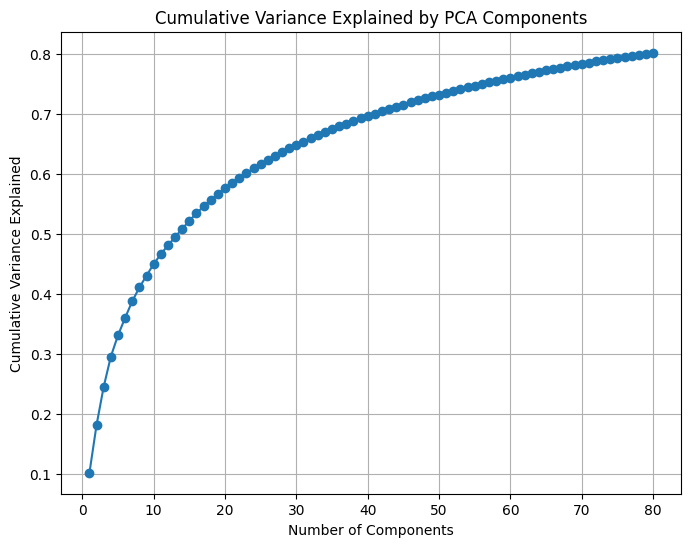

In [16]:
print(model_pca.explainedVariance)

# Plot
explained_variance_ratios = model_pca.explainedVariance.toArray()

# Compute cumulative explained variance
cumulative_variance = np.cumsum(explained_variance_ratios)

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
plt.title('Cumulative Variance Explained by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.grid(True)
plt.show()


In [17]:
# delete feature extraction col & vectors (étapes intermédiaires, plus nécessaire.)
result_pca = result_pca.drop('features', 'vectors')
result_pca.show()


+--------------------+--------------+--------------------+
|                path|         label|        pca_features|
+--------------------+--------------+--------------------+
|gs://data-fruits-...|    Watermelon|[-2.4249786636445...|
|gs://data-fruits-...|    Watermelon|[-2.7799545500016...|
|gs://data-fruits-...|    Watermelon|[-3.1644799536904...|
|gs://data-fruits-...|Pineapple Mini|[-4.0141380624435...|
|gs://data-fruits-...|    Watermelon|[-3.0128143613329...|
|gs://data-fruits-...|    Watermelon|[-2.7552698720395...|
|gs://data-fruits-...|Pineapple Mini|[-5.7987034084120...|
|gs://data-fruits-...|    Watermelon|[-3.4565029230045...|
|gs://data-fruits-...|    Watermelon|[-2.8892628352288...|
|gs://data-fruits-...|   Cauliflower|[-5.1077531308632...|
|gs://data-fruits-...|    Watermelon|[-2.1608278134407...|
|gs://data-fruits-...|     Raspberry|[0.10498766080780...|
|gs://data-fruits-...|   Cauliflower|[-4.4592071200146...|
|gs://data-fruits-...|     Raspberry|[-1.7246614930289..

### 3.4 Save final results


In [18]:
# Save
PATH_Result_PCA = "gs://data-fruits-p8/pca"

# result_pca.write.mode("overwrite").parquet(PATH_Result_PCA)
print('\n', 'Copied')



 Copied


In [20]:
# show bucket using cli ssh ?
# ou directement avec l'ui
